In this notebook, we show that the choice of sparsity basis for traditional compressed sensing methods doesn't matter when measuring the robustness to adversarial perturbations and all bases are vulnerable to those attacks.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0,'/root/bart-0.6.00/python/')
import bart
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"

import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import RandomMaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel
from DIP_UNET_models.unet_and_tv.varnet import VariationalNetworkModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import torch.nn as nn
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 2
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor
devices = [torch.device("cuda:2"),
           torch.device("cuda:2"),
           torch.device("cuda:1"),
           torch.device("cuda:0"),]

num GPUs 4


# Load the data and create a mask

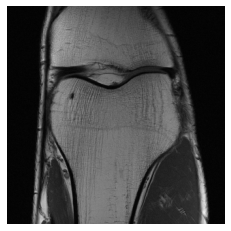

In [53]:
file = 'file1000769.h5'
eps = 0.08
filename = '/data/knee/multicoil_val/' + file

f = h5py.File(filename, 'r')
slicenu = f["kspace"].shape[0]//2
slice_ksp = f['kspace'][slicenu]
slice_ksp_torchtensor = transform.to_tensor(slice_ksp)
ksp = slice_ksp_torchtensor.clone()
orig = f['reconstruction_rss'][slicenu]

plt.imshow(orig,'gray')
plt.axis('off')
plt.show()

In [54]:
##### mask #####
desired_factor = 4 # desired under-sampling factor
undersampling_factor = 0
tolerance = 0.03
while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
    mask_func = RandomMaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
    mask1d = var_to_np(mask)[0,:,0]
    undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]
mask2d = np.repeat(mask1d[None,:], slice_ksp_torchtensor.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp_torchtensor.shape[2]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

# Evaluation function

In [55]:
def psnr_(im1,im2):
    # im1: ground truth
    # im2: reconstruction
    im1 = (im1-im1.mean()) / im1.std()
    im1 *= im2.std()
    im1 += im2.mean()
    s = psnr(np.array([im1]),np.array([im2]))
    return s

# Required functions

In [56]:
import torch_dct as dct
from pytorch_wavelets import DWTForward, DWTInverse
xfm = DWTForward(J=3, mode='zero', wave='db3').cuda(gpu)

def l1_reconstruction(ksp, mask, orig, num_iters = 1000, lam=1e-2,LR=1e-1,basis='wavelet'):
    # basis = ['wavelet','fourier','dct']
    unders, _ = transform.apply_mask(ksp, mask = mask)
    mse = torch.nn.MSELoss()
    x = Variable(torch.zeros(unders.shape[1:])).type(dtype).to(devices[0])
    x.requires_grad = True
    
    zpad = unders.data.cpu().numpy()
    zpad_complex = []
    for m in range(zpad.shape[0]):
        zpad_complex += [zpad[m,:,:,0]+1j*zpad[m,:,:,1]]
    zpad_complex = np.array(zpad_complex)
    zpad_complex.shape
    masked_complex_kspace = zpad_complex * np.array(ksp.shape[0]*[list(mask2d)]) # shape: (15, 640, 368)
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_complex_kspace,0,2)]))
    sens_maps = np.moveaxis(sens_maps[0],2,0)
    
    optimizer = torch.optim.SGD([x], lr=LR)
    S = transform.to_tensor(sens_maps).type(dtype).to(devices[0])
    L = []
    trL = []
    for i in range(num_iters):
        def closure():
            imgs = torch.zeros(S.shape).type(dtype).to(devices[0])
            for j,s in enumerate(S):
                imgs[j,:,:,0] = x[:,:,0] * s[:,:,0] - x[:,:,1] * s[:,:,1]
                imgs[j,:,:,1] = x[:,:,0] * s[:,:,1] + x[:,:,1] * s[:,:,0]
            optimizer.zero_grad()
            out,_ = transform.apply_mask(transform.fft2(imgs),mask=mask.to(devices[0]))
            
            if basis == 'wavelet':
                Rx, Ux = xfm(x[None,:].permute(0,3,1,2))
            elif basis == 'fourier':
                Rx = transform.fft2(x)
            elif basis == 'dct':
                Rx = dct.dct_2d(x)
            loss = mse( out , unders.type(dtype).to(devices[0]) ) + lam*torch.norm(Rx,p=1)
            loss.backward(retain_graph=True)
            if i % 100 == 0:
                print("iteration{} -- fitting loss: {}".format(i,loss.data),"\r",end='')
                L.append(loss.data.cpu().numpy()[np.newaxis][0])
            return loss
        loss = optimizer.step(closure)
    
    rec = center_crop(transform.complex_abs(x).data.cpu().numpy(),(320,320))
    Psnr = psnr_(orig,rec)
    return rec, Psnr, sens_maps

In [57]:
def l1_attacker(ksp, mask, sens_maps, gt ,num_iters = 1000, lam=1e-2,lam1=1e-1,LR=1e-1,weight_decay=0,eps=0.04, basis='wavelet'):
    # basis = ['wavelet','fourier','dct']
    mse = torch.nn.MSELoss()
    ### output image
    x = Variable(torch.zeros(ksp.shape[1:])).type(dtype)
    x.requires_grad = True
    ### perturbation
    e = Variable(torch.zeros(ksp.shape)).type(dtype)
    e.data.uniform_()
    e *= torch.norm(ksp)/torch.norm(e) / 10000
    e.requires_grad = True
    
    optimizer = torch.optim.SGD([x,e], lr=LR,weight_decay=weight_decay)
    S = transform.to_tensor(sens_maps).type(dtype)
    
    L = []
    E = []
    lam11 = 0
    norm_ratios = []
    ctr = 0
    for i in range(num_iters):
        if i > 100:
            unders, _ = transform.apply_mask(ksp.type(dtype)+e, mask = mask.type(dtype))
            lam11 = lam1
        else:
            unders, _ = transform.apply_mask(ksp.type(dtype), mask = mask.type(dtype))
        def closure():
            imgs = torch.zeros(S.shape).type(dtype)
            for j,s in enumerate(S):
                imgs[j,:,:,0] = x[:,:,0] * s[:,:,0] - x[:,:,1] * s[:,:,1]
                imgs[j,:,:,1] = x[:,:,0] * s[:,:,1] + x[:,:,1] * s[:,:,0]
            optimizer.zero_grad()
            out,_ = transform.apply_mask(transform.fft2(imgs),mask=mask) #transform.fft2(x)*mask
            
            if basis == 'wavelet':
                Rx, Ux = xfm(x[None,:].permute(0,3,1,2))
            elif basis == 'fourier':
                Rx = transform.fft2(x)
            elif basis == 'dct':
                Rx = dct.dct_2d(x)
                
            loss = mse( out , unders ) + lam*torch.norm(Rx,p=1) - lam11 * mse(gt,imgs) 
            loss.backward()
            if i % 10 == 0:
                print("iteration{} -- fitting loss: {} pertn/kspn: {}".format(i,
                       loss.data,torch.norm(e)/torch.norm(ksp)),"\r",end='')
                L.append(loss.data.cpu().numpy()[np.newaxis][0])
            return loss
        loss = optimizer.step(closure)
        
        ### projection onto the l2-norm ball denoted by eps 
        if torch.norm(e.data) / torch.norm(ksp) > eps:
            e.data = e.data * torch.norm(ksp) / (torch.norm(e.data) + 1e-10) # 1e-10 is a stabilizer
            e.data = e.data * eps
            ctr += 1
        ###
        E.append(e.data.cpu())
        
        norm_ratios = [torch.norm(e)/torch.norm(ksp)] + norm_ratios
        ### ending constraints
        if ctr > 100: # if more than 100 projections have been done
            break
        if len(norm_ratios) >= 200: # if the perturbation norm doesn't change more than 0.01 over 200 iterations
            if norm_ratios[0] - norm_ratios[-1] < 0.01:
                break
            else:
                norm_ratios.pop()
    return x,E

# Wavelet basis

In [68]:
num_iters = 1500

In [69]:
### clean reconstruction
wav_clean_rec, wav_clean_ssim, sens = l1_reconstruction(ksp, mask, orig, num_iters = num_iters, lam=1e-12,LR=1e5,basis='wavelet')

In [70]:
### attack
outw, Ew = l1_attacker(ksp.to(devices[0]), mask.to(devices[0]), sens, transform.ifft2(ksp.type(dtype).to(devices[0])), num_iters=300,lam=1e-12,lam1=1,LR=1e5,eps=0.08)
### perturbed reconstruction
wav_pert_rec, wav_pert_ssim, _ = l1_reconstruction(ksp+Ew[-1], mask, orig, num_iters = num_iters, lam=1e-12,LR=1e5,basis='wavelet')

# Fourier basis

In [71]:
### clean reconstruction
f_clean_rec, f_clean_ssim, sens = l1_reconstruction(ksp, mask, orig, num_iters = num_iters, lam=1e-12,LR=1e5,basis='fourier')

In [72]:
### attack
outf, Ef = l1_attacker(ksp.to(devices[0]), mask.to(devices[0]), sens, transform.ifft2(ksp.type(dtype).to(devices[0])), num_iters=300,lam=1e-12,lam1=1,LR=1e5,eps=0.08,basis='fourier')
### perturbed reconstruction
f_pert_rec, f_pert_ssim, _ = l1_reconstruction(ksp+Ef[-1], mask, orig, num_iters = num_iters, lam=1e-12,LR=1e5,basis='fourier')

# Discrete Cosine Transform basis

In [73]:
### clean reconstruction
dct_clean_rec, dct_clean_ssim, sens = l1_reconstruction(ksp, mask, orig, num_iters = num_iters, lam=1e-14,LR=1e5,basis='dct')

In [74]:
### attack
outd, Ed = l1_attacker(ksp.to(devices[0]), mask.to(devices[0]), sens, transform.ifft2(ksp.type(dtype).to(devices[0])), num_iters=300,lam=1e-14,lam1=1,LR=1e5,eps=0.08,basis='dct')
### perturbed reconstruction
dct_pert_rec, dct_pert_ssim, _ = l1_reconstruction(ksp+Ed[-1], mask, orig, num_iters = num_iters, lam=1e-14,LR=1e5,basis='dct')

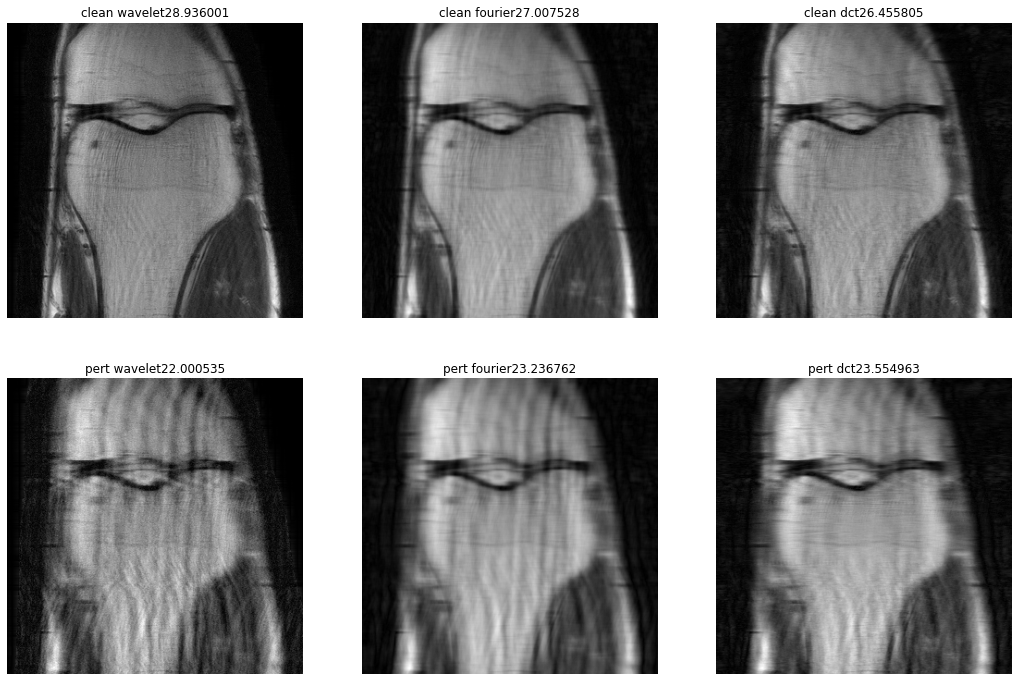

In [75]:
fig = plt.figure(figsize=(18,12))
plots = [wav_clean_rec,f_clean_rec,dct_clean_rec,
         wav_pert_rec ,f_pert_rec ,dct_pert_rec]
S = [wav_clean_ssim,f_clean_ssim,dct_clean_ssim,
         wav_pert_ssim ,f_pert_ssim ,dct_pert_ssim]
bs = ['clean wavelet', 'clean fourier', 'clean dct','pert wavelet', 'pert fourier', 'pert dct']
for i,p in enumerate(plots):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(p,'gray')
    ax.axis('off')
    ax.set_title(bs[i] + '%3f'%(S[i]))
plt.show()